## Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Loading the model

In [12]:
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

models_dir = "../../models"
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=os.path.join(models_dir, sam_checkpoint))
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

### Loading the image

In [3]:
image_path = '../images/1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

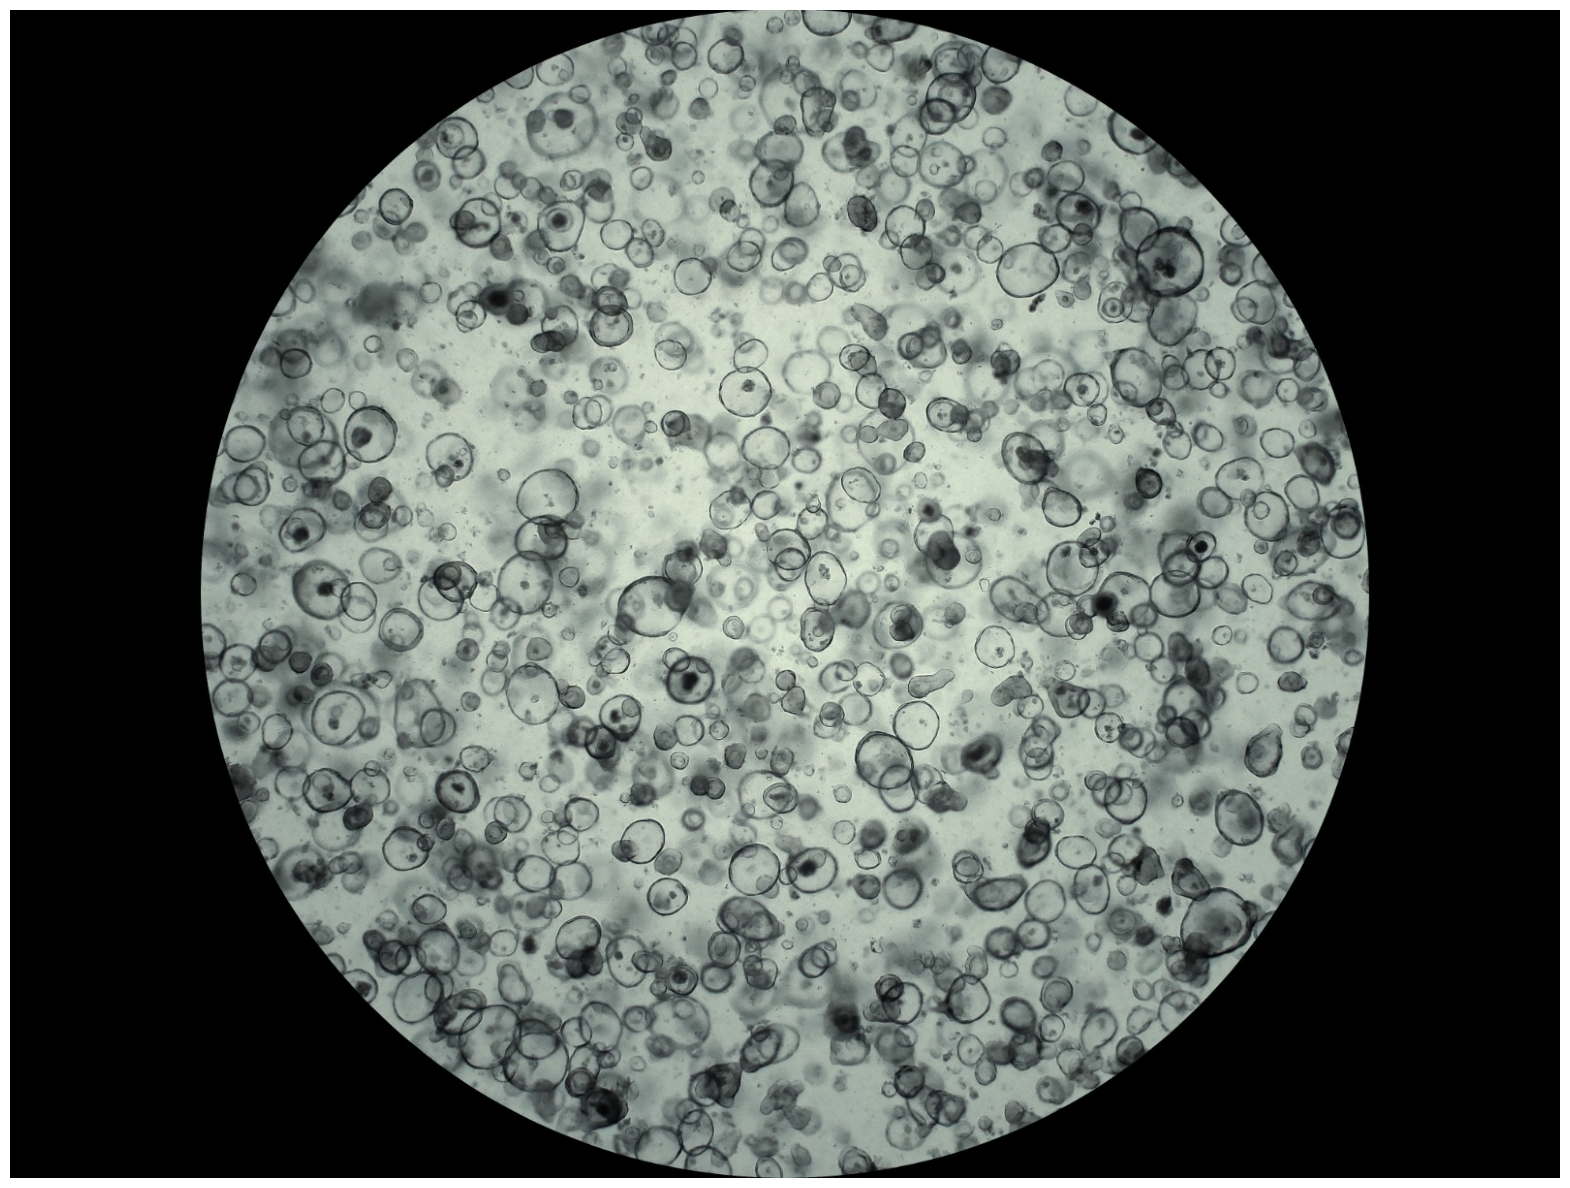

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

### Generating masks (default parameters)

In [13]:
masks = mask_generator.generate(image)

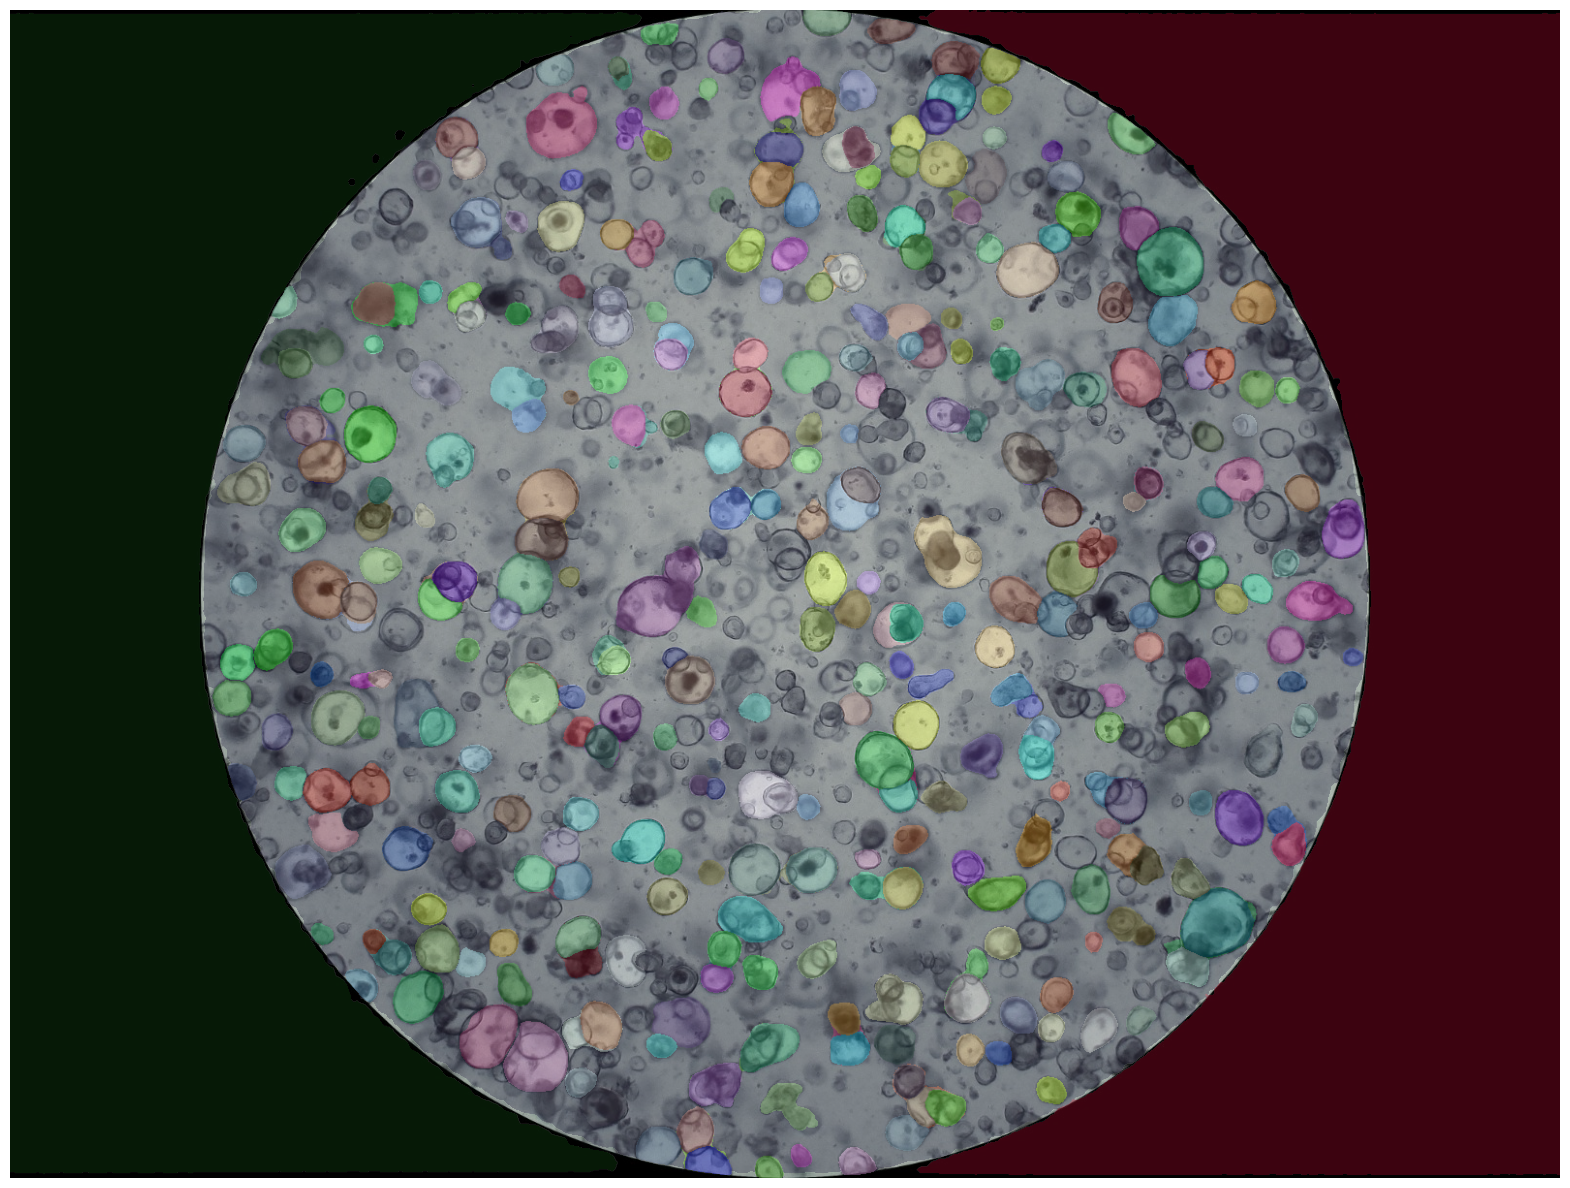

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Saving mask to folder

In [22]:
from typing import List, Any, Dict

def write_masks_to_folder(masks: List[Dict[str, Any]], path: str) -> None:
    header = "id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h"  # noqa
    metadata = [header]
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        filename = f"{i}.png"
        cv2.imwrite(os.path.join(path, filename), mask * 255)
        mask_metadata = [
            str(i),
            str(mask_data["area"]),
            *[str(x) for x in mask_data["bbox"]],
            *[str(x) for x in mask_data["point_coords"][0]],
            str(mask_data["predicted_iou"]),
            str(mask_data["stability_score"]),
            *[str(x) for x in mask_data["crop_box"]],
        ]
        row = ",".join(mask_metadata)
        metadata.append(row)
    metadata_path = os.path.join(path, "metadata.csv")

    if not os.path.exists(metadata_path):
        os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
        with open(metadata_path, "a") as f: pass

    with open(metadata_path, "w") as f:
        f.write("\n".join(metadata))

    return


In [4]:
masks_folder = "../masks/"

In [23]:
write_masks_to_folder(masks, masks_folder)

## Create graph

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv(masks_folder + 'metadata.csv')

# Extract the "area" column
areas = df['area']

# Sort the areas in ascending order
sorted_areas = areas.sort_values(ascending=True)
# Discard the three highest numbers (outliers)
trimmed_areas = sorted_areas.iloc[:-3]



Scatter plot

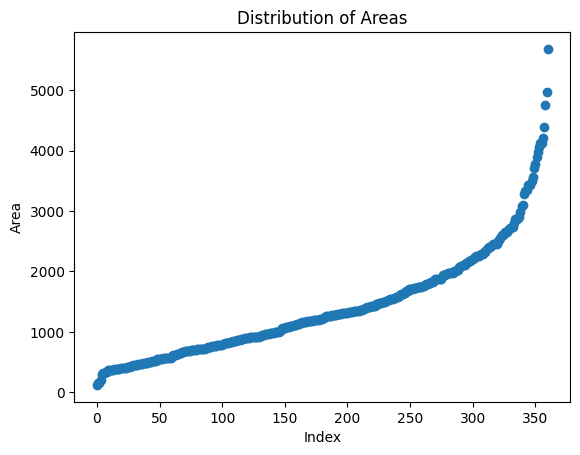

In [18]:
# Create a scatter plot
plt.scatter(range(len(trimmed_areas)), trimmed_areas)

# Set plot title and labels
plt.title('Distribution of Areas')
plt.xlabel('Index')
plt.ylabel('Area')

# Show the plot
plt.show()

Histogram

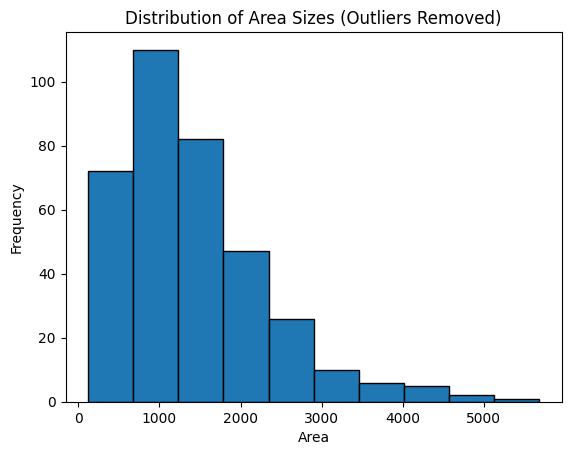

In [20]:
plt.hist(trimmed_areas, bins=10, edgecolor='black')

# Set plot title and labels
plt.title('Distribution of Area Sizes (Outliers Removed)')
plt.xlabel('Area')
plt.ylabel('Frequency')

# Show the plot
plt.show()